In [ ]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import sqlite3
sqlite3.register_adapter(np.int64, int)
import re
import math
from datetime import date
import matplotlib.pyplot as plt

# 展開所有dataframe columns
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option ('display.max_colwidth',500)

# 不縮寫成科學記號
pd.set_option('display.float_format',lambda x : '%.2f' % x)

db = sqlite3.connect('./stock.db' , isolation_level=None)

In [ ]:
# 下次換季時間： 8/14, 11/14, 3/31, 5/15
QUARTERS = ['2022q3','2022q4','2023q1','2023q2']
CURRENT_QUARTER = QUARTERS[-1][-2:]
CURRENT_QUARTERS = list(map(lambda q: q[-2:], QUARTERS))
CURRENT_YEAR = int(QUARTERS[-1][0:4])
LAST_YEAR_QUARTER = '2022q4'
CURRENT_YEARS = [2018, 2019, 2020, 2021, 2022]
print("QUARTERS:", QUARTERS)
print("CURRENT_QUARTER:", CURRENT_QUARTER)
print("CURRENT_QUARTERS:", CURRENT_QUARTERS)
print("CURRENT_YEAR:", CURRENT_YEAR)
print("LAST_YEAR_QUARTER:", LAST_YEAR_QUARTER)
print("CURRENT_YEARS:", CURRENT_YEARS)

In [ ]:
# 查詢股本table
df_stock_id_name = pd.read_sql_query("select * from stockIdName",db)
print(len(df_stock_id_name))
df_stock_id_name.head()

In [ ]:
out = df_stock_id_name[['id', 'name', 'market', 'industry', 'capital']]
out.head()

In [ ]:
ids = out['id'].tolist()

# 用的到的table(加速運算時間,不用每個id都查db)

In [ ]:
# 月營收
monthly = pd.read_sql_query(f"select * from monthlyRevenue order by date" , db)
# 日收盤
daily = pd.read_sql_query("select * from daily",db)
daily = daily.sort_values(by=['date'])
# 現金流量表
cashflow = pd.read_sql_query("select * from cashflow order by date",db)
# 財報
df_financial_statement = pd.read_sql_query("select * from financialStatement order by date",db)
df_financial_statement = df_financial_statement.fillna(0)
df_financial_statement.replace('--', 0, inplace=True)
# 負債表
df_debt = pd.read_sql_query(f"select * from balanceSheet order by date",db)

# YoY > 0筆數

月營收yoy>0筆數

In [ ]:
def countYoYGreaterThan0(id):
    df = monthly[(monthly['id']==id) & (monthly['YoY'] > 0)]
    
    try:
        return len(df)
    except:
        return np.nan
    
count = [countYoYGreaterThan0(id) for id in ids]
out['yoy>0次數'] = count

/var/folders/x4/j_5l0k9n7638q__cc_ptz1180000gn/T/ipykernel_63748/668954957.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out['yoy>0次數'] = count


In [8]:
out.sort_values(by=['yoy>0次數'], ascending=False).head(10)

,id,name,industry,capital,yoy>0次數
1179,3587,閎康,其他電子業,0.62,67
521,3023,信邦,電子零組件業,2.36,67
1570,6469,大樹,生技醫療業,0.89,66
1081,3218,大學光,生技醫療業,0.80,66
914,8454,富邦媒,貿易百貨業,2.18,66
623,3653,健策,電子零組件業,1.34,65
841,6592,和潤企業,其他業,5.15,65
1600,6561,是方,通信網路業,0.71,65
960,9941,裕融,其他業,5.47,65
1717,8284,三竹,資訊服務業,0.46,64


# 月營收

In [ ]:
# 近12月營收平均
def TTMRevenueCal(id):
    df = monthly[(monthly['id']==id)].tail(12)
    
    try:
        TTMRevenue = round((df['revenue'].sum()/100000),2)
        TTMYoY = round(df['sumYoY'].mean() ,2)
        return TTMRevenue, TTMYoY
    except:
        return np.nan

out['TTMRevenue'] = [TTMRevenueCal(id)[0] for id in ids]
out['TTMYoY'] = [TTMRevenueCal(id)[1] for id in ids]

In [ ]:
out[out['id'].isin([2330,3037])]

id name industry  capital  yoy>0次數   近12月營收  sumYoY
274  2330  台積電     半導體業   259.30       53 22190.02   20.06
360  2454  聯發科     半導體業    15.99       46  4350.15  -14.63
535  3037   欣興   電子零組件業    14.75       56  1227.34    6.72

# 毛利率(Gross Profit Margin)
# 營業利益率(Operating profit Margin)
# 淨利率(Net profit margin)

In [ ]:
df_financial_statement['grossProfitMargin'] = df_financial_statement['grossProfit'].div(df_financial_statement['revenue'])
df_financial_statement['operatingProfitMargin'] = df_financial_statement['operatingIncome'].div(df_financial_statement['revenue'])
df_financial_statement['netProfitMargin'] = df_financial_statement['income'].div(df_financial_statement['revenue'])

In [ ]:
out[out['id'].isin([2330,2454,3037])]

id name industry  capital  yoy>0次數   近12月營收  sumYoY  毛利率q2  毛利率q3  毛利率q4  毛利率q1  營業利益率q2  營業利益率q3  營業利益率q4  營業利益率q1  淨利率q2  淨利率q3  淨利率q4  淨利率q1
274  2330  台積電     半導體業   259.30       53 22190.02   20.06   0.57   0.59   0.60   0.56     0.47     0.49     0.50     0.45   0.43   0.44   0.45   0.41
360  2454  聯發科     半導體業    15.99       46  4350.15  -14.63   0.50   0.50   0.49   0.48     0.25     0.25     0.23     0.15   0.23   0.23   0.22   0.18
535  3037   欣興   電子零組件業    14.75       56  1227.34    6.72   0.35   0.36   0.36   0.21     0.26     0.28     0.27     0.11   0.22   0.22   0.22   0.16

# EPS

In [ ]:
# 近四季eps
def nearFourQuarterEPS(id):
    try:
        fid = df_financial_statement['id'] == id
        return round(df_financial_statement[fid].sort_values(by=['date']).tail(4)['qeps'].sum(), 2)
    except:
        return np.nan

# nearFourQuarterEPS(4977)

out['eps'] = [nearFourQuarterEPS(id) for id in ids]

In [ ]:
# 上年eps
def lastYearEPS(id):
    try:
        isId = df_financial_statement['id'] == id
        isLastYear = df_financial_statement['date'].str.contains(LAST_YEAR_QUARTER)
        return df_financial_statement[isId & isLastYear]['eps'].iloc[0]
    except:
        return np.nan 
    
out['last_eps'] = [lastYearEPS(id) for id in ids]

# 收盤價

In [ ]:
def recentClose(id):
    try:
        return daily[daily['id']==id].tail(1).iloc[0]['close']
    except:
        return np.nan
    
out['收盤價'] = [recentClose(id) for id in ids]

# 現金流量

In [ ]:
# 近四季自由現金
def calFreeCashFlow(id):
    try:
        df = cashflow[cashflow['id']==id].tail(4)
        return df['qcashflow'].sum() / 1e5
    except:
        return np.nan

out['freeCashFlow'] = [calFreeCashFlow(id) for id in ids]

In [ ]:
# 近5年自由現金流平均
def FiveYearsFreeCashFlowAvg(id):
    try:
        df = cashflow[(cashflow['id']==id) & (cashflow['date'].str.contains('q4'))].tail(5)
        freeCash = df['operating'] + df['investing']
        return round(freeCash.mean() / 1e5, 2)
    except:
        return np.nan
    
out['freeCashFlow5Y'] = [FiveYearsFreeCashFlowAvg(id) for id in ids]

In [21]:
out[out['id'].isin([5483,2454,3037,9103])]

,id,name,industry,capital,yoy>0次數,近12月營收,sumYoY,毛利率q2,毛利率q3,毛利率q4,毛利率q1,營業利益率q2,營業利益率q3,營業利益率q4,營業利益率q1,淨利率q2,淨利率q3,淨利率q4,淨利率q1,eps,last_eps,收盤價,cashflowPositiveRate,cashflowSum
360,2454,聯發科,半導體業,15.99,46,4350.15,-14.63,0.50,0.50,0.49,0.48,0.25,0.25,0.23,0.15,0.23,0.23,0.22,0.18,64.21,74.59,693.00,100.00,495358999
535,3037,欣興,電子零組件業,14.75,56,1227.34,6.72,0.35,0.36,0.36,0.21,0.26,0.28,0.27,0.11,0.22,0.22,0.22,0.16,18.93,20.08,177.00,100.00,186487982
977,9103,美德醫療-DR,None,0.00,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,6.02,NaN,0
1420,5483,中美晶,半導體業,5.86,46,832.75,13.17,0.40,0.40,0.39,0.36,0.33,0.32,0.31,0.28,0.14,0.18,0.20,0.23,16.92,14.87,158.50,100.00,163725644


# 負債

In [ ]:
def debt(id):
    df = df_debt[df_debt['id']==id].tail(1)
    df['debtRate'] = df['liabilities'] / df['asset']
    try:
        return round(df['debtRate'].iloc[0] ,2)
    except:
        return np.nan

out['debt'] = [debt(id) for id in ids]

# 市值

In [ ]:
out['marketCap'] = out['收盤價'] * out['capital']
df_marketCap = out.sort_values(by=['marketCap'], ascending=False).head(50)
df_marketCap[['id', 'name', 'industry', 'capital', 'marketCap', 'eps', '收盤價', ]].head(10)

,id,name,industry,capital,marketCap,eps,收盤價
274,2330,台積電,半導體業,259.30,142874.30,39.36,551.00
267,2317,鴻海,其他電子業,138.63,15249.30,9.02,110.00
360,2454,聯發科,半導體業,15.99,11081.07,64.21,693.00
329,2412,中華電,通信網路業,77.57,9153.26,4.77,118.00
476,2881,富邦金,金融保險業,139.95,9152.73,4.71,65.40
262,2308,台達電,電子零組件業,25.98,9131.97,12.91,351.50
311,2382,廣達,電腦及週邊設備業,38.63,8131.62,7.44,210.50
826,6505,台塑化,油電燃氣業,95.26,7754.16,0.55,81.40
478,2882,國泰金,金融保險業,147.03,6851.60,3.94,46.60
424,2603,長榮,航運業,52.91,5661.37,70.29,107.00


# MA

In [25]:
def ma(id, day):
    df_close = daily[daily['id'] == id]
    try:
        return round(df_close.tail(day)['close'].mean(), 2)
    except:
        return np.nan
out['ma20'] = [ma(id, 20) for id in ids]
out['ma60'] = [ma(id, 60) for id in ids]
out['ma120'] = [ma(id, 120) for id in ids]

# PE, EPS_INCREASE, PEG

In [ ]:
# pe
series_pe = round(out['收盤價']/out['eps'] ,2)
out['pe'] = series_pe

# eps_increase
out['eps_increase'] = round(100*(out['eps']-out['last_eps'])/out['last_eps'], 2)

# peg
out['peg'] = round(out['pe']/out['eps_increase'], 2)

In [ ]:
def cal_avg_pe(id):
    df = daily[daily['id']==id]
    try:
        return round(df['pe'].mean(), 2)
    except:
        return np.nan

out['avg_pe'] = [cal_avg_pe(id) for id in ids]

## 筆數

In [ ]:
today = '20230810'
print('總家數:', len(out))
print('市值大於50億家數:', len(out[out['marketCap'] > 50]))
print(f'市值加總: {round(out["marketCap"].sum()/1e4, 2)}兆')

總家數: 1780
市值大於50億家數: 839
市值加總: 57.19兆


## DCF

In [ ]:
def epsDcf(eps, cagr = 0.02):
    r = 0.08   # 折現率, 希望報酬, 大盤平均報酬, WACC
    g = 0.02  # 永續成長率
    COUNT_YEAR = 5
    EV = 0     # 企業價值(每年eps折現加總+最終價值tv)

    for year in range(1, COUNT_YEAR + 1):
        FCF = round(eps * pow(1 + cagr, year), 2)
        discountFCF = round(FCF / pow((1 + r), year), 2)
        EV += discountFCF

        if(year == COUNT_YEAR):
            TV = (discountFCF * (1 + g)) / (r - g)
            TV = round(TV / (pow((1 + r), COUNT_YEAR)) , 2)
            EV += TV
    
    return EV

out['epsDcf'] = epsDcf(out['eps'])

In [ ]:
def cashflowDcf(cashflow, cagr = 0.02):
    r = 0.08   # 折現率, 希望報酬, 大盤平均報酬, WACC
    g = 0.02  # 永續成長率
    COUNT_YEAR = 5
    EV = 0     # 企業價值(每年eps折現加總+最終價值tv)

    for year in range(1, COUNT_YEAR + 1):
        FCF = round(cashflow * pow(1 + cagr, year), 2)
        discountFCF = round(FCF / pow((1 + r), year), 2)
        EV += discountFCF

        if(year == COUNT_YEAR):
            TV = (discountFCF * (1 + g)) / (r - g)
            TV = round(TV / (pow((1 + r), COUNT_YEAR)) , 2)
            EV += TV
    return EV

def calCashflowDcf(id, cagr = 0.02):
    df = out[out['id']==id]
    freeCashFlow = df['freeCashFlow'].iloc[0]
    
    df_ids = df_stock_id_name[df_stock_id_name['id']==id]
    capital = df_ids['capital'].iloc[0]
    
    return round(cashflowDcf(freeCashFlow, cagr)/capital, 2)

out['cashflowDcf'] = [calCashflowDcf(id) for id in ids]

In [ ]:
out[out['id'].isin([2454,2330])]

id name industry  capital  yoy>0次數  近12月營收  sumYoY  毛利率q2  毛利率q3  毛利率q4  毛利率q1  營業利益率q2  營業利益率q3  營業利益率q4  營業利益率q1  淨利率q2  淨利率q3  淨利率q4  淨利率q1   eps  last_eps    收盤價  cashflowPositiveRate  cashflowSum  debt  marketCap   ma20   ma60  ma120    pe  eps_increase   peg  avg_pe
360  2454  聯發科     半導體業    15.99       46 4441.42   -9.85   0.50   0.50   0.49   0.48     0.25     0.25     0.23     0.15   0.23   0.23   0.22   0.18 64.21     74.59 701.00                100.00    495358999  0.45   11208.99 687.35 711.52 719.89 10.92        -13.92 -0.78   21.82

# ROE

In [ ]:
def roe(id):
    try:
        debt = df_debt[df_debt['id']==id].tail(1)
        shareholderEquity = debt['shareholderEquity'].iloc[0]

        financial_statement = df_financial_statement[df_financial_statement['id']==id].tail(2)
        income = financial_statement['income'].iloc[0]
        return round(income*100/shareholderEquity , 2)
    except:
        return np.nan

out['roe'] = [roe(id) for id in ids]

In [ ]:
features = out[['id','name','market','industry','count','capital','marketCap','debt','ma20','ma60','ma120','TTMRevenue','TTMYoY','freeCashFlow','freeCashFlow5Y','roe','last_eps','eps','eps_increase','yoyIncreaseCount','pe','avg_pe','peg','收盤價','epsDcf','cashflowDcf']]
features.to_csv(f"features.csv", index = False)

# 統計數字

In [ ]:
today = '20230815'
print('總家數:', len(out))
print('市值大於50億家數:', len(out[out['marketCap'] > 50]))
print(f'市值加總: {round(out["marketCap"].sum()/1e4, 2)}兆')

In [ ]:
# 在季線上家數
upMa60 = len(out[out['收盤價'] > out['ma60']])
percent = round(len(out[out['收盤價'] > out['ma60']])*100/len(out), 2)
print(f'在季線上家數: {upMa60} ({percent}%)')
upMa120 = len(out[out['收盤價'] > out['ma120']])
percent120 = round(len(out[out['收盤價'] > out['ma120']])*100/len(out), 2)
print(f'在半年線上家數: {upMa120} ({percent120}%)')


In [ ]:
out[out['id'].isin([4977])]

## 選股
* roe > 5 (194)
* 股價 < dfc(eps and cashflow) (28)
* 排除航運 (27)
* 5年free cashflow > 0 (26)

In [ ]:
filter = out
roe = (filter['roe'] > 5)
dcf = (filter['收盤價'] < filter['epsDcf']) & ((filter['收盤價'] < filter['cashflowDcf']))
industry = (filter['industry'] != '航運業')
freeCashFlow5Y = (filter['freeCashFlow5Y'] > 0)

filter2 = filter[roe & dcf & industry & freeCashFlow5Y]
print(len(filter2), "\n")
print("、".join([f"{row['id']}{row['name']}" for index, row in filter2.iterrows()]))
filter2

# 選股
* 本益比 < 20
* eps > 3
* marketCap(市值) > 50億
* yoyCount(yoy>0次數) > 0
* industry(產業) 排除生技醫療業、航運業
* grossmargin(毛利率) > 0.2
* profit(淨利率), operating(營業利益率) > 0
* cashflowSum(現金流) > 0
* 自由現金流為正 > 0
* count至少有一年資料 > 240

In [29]:
filter = out
industry = (filter['industry'] != '生技醫療業') & (filter['industry'] != '航運業') & (filter['industry'] != '文化創意業')
eps = (filter['eps'] > 3) 
pe = (filter['pe'] <= 20) & (filter['pe'] > 0)
marketCap = (filter['marketCap'] > 50) 
freeCashFlow = (filter['freeCashFlow'] > 0)
yoyCount = (filter['yoyIncreaseCount'] > 0)
freeCashFlow5Y = (filter['freeCashFlow5Y'] > 0)
count = (filter['count'] > 240)
roe = (filter['roe'] > 0)

filter1 = filter[eps & pe & count & freeCashFlow & freeCashFlow5Y & roe & industry] 

print(f'{len(filter1)} 筆')

filter1

152 筆


In [30]:
# 產業分布
group = filter1.groupby(by=['industry']).agg({'id': len, 'name': ', '.join}).sort_values(by=['id'], ascending=False)
group

,id,name
industry,,
半導體業,35,"聯電, 台積電, 瑞昱, 京元電子, 創見, 聯發科, 強茂, 聯陽, 聯詠, 景碩, 京鼎..."
電子零組件業,24,"國巨, 新巨, 興勤, 志聖, 立隆電, 鉅祥, 大毅, 希華, 揚博, 健和興, 欣興, ..."
其他業,21,"八貫, 拓凱, jpp-KY, 桂盟, 中租-KY, 大豐電, 鋼聯, 復盛應用, 可寧衛,..."
電腦及週邊設備業,13,"神基, 威強電, 融程電, 凌華, 飛捷, 宏正, 研揚, 振樺電, 艾訊, 安勤, 鼎翰,..."
其他電子業,11,"震旦行, 互盛電, 德律, 碩天, 貿聯-KY, 巨路, 迅得, 鼎炫-KY, 宜特, 耕興..."
電機機械,9,"鑽全, 中砂, 直得, 上銀, 台灣精銳, 新麥, 崇友, 瑞穎, 皇田"
通信網路業,7,"耀登, 合勤控, 瑞祺電通, 波若威, 立端, 普萊德, 正基"
化學工業,6,"興農, 中碳, 永記, 南寶, 上品, 聚和"
汽車工業,5,"東陽, 劍麟, 宇隆, 智伸科, 帝寶"


In [ ]:
filter1.to_csv(f"filter1.csv", index = False)

In [31]:
ma20 = filter1['ma20']
ma60 = filter1['ma60']
ma120 = filter1['ma120']
ma20_60 = ma20 >= ma60
ma60_120 = ma60 >= ma120
ma20_120 = ma20 >= ma120
print('多頭結構：')
filter_long = filter1[ma20_60 & ma60_120 & ma20_120]
long_ids = filter_long['id'].tolist()
filter_long

多頭結構：


,id,name,industry,capital,yoy>0次數,近12月營收,sumYoY,毛利率q2,毛利率q3,毛利率q4,毛利率q1,營業利益率q2,營業利益率q3,營業利益率q4,營業利益率q1,淨利率q2,淨利率q3,淨利率q4,淨利率q1,eps,last_eps,收盤價,cashflowPositiveRate,cashflowSum,debt,marketCap,ma20,ma60,ma120,pe,eps_increase,peg,avg_pe
40,1319,東陽,汽車工業,5.91,33,220.47,10.33,0.22,0.23,0.24,0.27,0.07,0.08,0.09,0.13,0.10,0.11,0.10,0.09,3.96,3.64,60.10,100.00,46703996,0.27,355.19,56.90,53.36,49.81,15.18,8.79,1.73,17.56
131,1560,中砂,電機機械,1.43,49,64.47,2.15,0.38,0.37,0.37,0.28,0.23,0.22,0.21,0.13,0.21,0.20,0.18,0.11,7.75,8.71,123.00,100.00,10668744,0.36,175.89,139.00,127.17,120.60,15.87,-11.02,-1.44,16.49
170,1726,永記,化學工業,1.62,45,95.70,2.87,0.22,0.22,0.22,0.24,0.09,0.08,0.09,0.11,0.09,0.08,0.08,0.09,4.98,5.03,75.90,100.00,8529874,0.14,122.96,75.62,75.46,74.33,15.24,-0.99,-15.39,15.12
249,2228,劍麟,汽車工業,0.76,41,46.18,11.07,0.23,0.25,0.26,0.24,0.07,0.10,0.10,0.10,0.08,0.11,0.10,0.08,6.29,5.97,87.40,100.00,5115019,0.27,66.42,97.41,93.81,88.47,13.90,5.36,2.59,19.16
309,2379,瑞昱,半導體業,5.13,56,966.24,-13.49,0.51,0.50,0.49,0.43,0.16,0.15,0.14,0.07,0.16,0.16,0.14,0.09,24.97,31.62,398.50,100.00,95656082,0.55,2044.31,415.52,398.24,387.97,15.96,-21.03,-0.76,18.71
335,2420,新巨,電子零組件業,1.53,27,23.22,-9.11,0.41,0.42,0.42,0.40,0.25,0.27,0.26,0.24,0.24,0.26,0.26,0.24,4.36,4.43,46.15,100.00,6567862,0.32,70.61,49.20,47.16,45.40,10.58,-1.58,-6.70,10.86
342,2428,興勤,電子零組件業,1.28,40,72.92,-4.66,0.38,0.37,0.35,0.38,0.22,0.21,0.19,0.23,0.22,0.22,0.19,0.18,9.96,10.72,169.50,100.00,12069489,0.30,216.96,164.62,160.62,154.62,17.02,-7.09,-2.40,11.94
356,2449,京元電子,半導體業,12.23,48,334.61,-3.19,0.37,0.36,0.36,0.33,0.26,0.26,0.25,0.21,0.21,0.20,0.19,0.16,5.07,5.59,61.10,100.00,103491558,0.47,747.25,63.05,57.76,52.01,12.05,-9.30,-1.30,13.17
379,2480,敦陽科,資訊服務業,1.06,53,71.44,8.26,0.27,0.26,0.26,0.26,0.13,0.12,0.12,0.14,0.11,0.11,0.11,0.12,7.19,6.91,115.00,90.00,4618622,0.59,121.90,119.47,118.30,108.42,15.99,4.05,3.95,13.67
380,2481,強茂,半導體業,3.83,33,123.27,-12.19,0.32,0.31,0.30,0.25,0.16,0.14,0.12,0.05,0.16,0.16,0.13,0.05,3.34,4.60,66.80,100.00,16853228,0.51,255.84,74.86,71.55,70.00,20.00,-27.39,-0.73,13.93


In [32]:
dev = 2
diff20_60 = abs((ma20-ma60)*100/ma60) <= dev
diff60_120 = abs((ma60-ma120)*100/ma120) <= dev
diff20_120 = abs((ma20-ma120)*100/ma120) <= dev

print('均線糾結:')
filter_torn = filter1[diff20_60 & diff60_120 & diff20_120]
torn_ids = filter_torn['id'].tolist()
filter_torn

均線糾結:


,id,name,industry,capital,yoy>0次數,近12月營收,sumYoY,毛利率q2,毛利率q3,毛利率q4,毛利率q1,營業利益率q2,營業利益率q3,營業利益率q4,營業利益率q1,淨利率q2,淨利率q3,淨利率q4,淨利率q1,eps,last_eps,收盤價,cashflowPositiveRate,cashflowSum,debt,marketCap,ma20,ma60,ma120,pe,eps_increase,peg,avg_pe
170,1726,永記,化學工業,1.62,45,95.70,2.87,0.22,0.22,0.22,0.24,0.09,0.08,0.09,0.11,0.09,0.08,0.08,0.09,4.98,5.03,75.90,100.00,8529874,0.14,122.96,75.62,75.46,74.33,15.24,-0.99,-15.39,15.12
251,2233,宇隆,汽車工業,0.60,37,31.64,-6.68,0.34,0.33,0.33,0.28,0.17,0.17,0.16,0.13,0.20,0.20,0.18,0.12,8.94,10.32,102.50,100.00,5359350,0.28,61.50,110.62,110.51,110.95,11.47,-13.37,-0.86,12.92
509,3008,大立光,光電業,1.33,26,448.22,-6.54,0.55,0.54,0.55,0.50,0.41,0.41,0.43,0.36,0.53,0.56,0.47,0.36,152.86,169.52,2125.00,100.00,267159700,0.19,2826.25,2193.00,2221.42,2198.33,13.90,-9.83,-1.41,17.68
584,3406,玉晶光,光電業,1.13,48,191.60,7.72,0.34,0.38,0.40,0.31,0.09,0.19,0.20,0.07,0.11,0.18,0.17,0.07,28.27,29.06,384.50,90.00,28042473,0.53,434.48,395.15,398.73,393.21,13.60,-2.72,-5.00,24.73
601,3532,台勝科,半導體業,3.88,45,158.03,11.69,0.38,0.38,0.38,0.35,0.32,0.32,0.32,0.29,0.29,0.32,0.29,0.24,12.13,12.43,146.50,100.00,47780925,0.38,568.42,158.32,160.44,158.28,12.08,-2.41,-5.01,33.11
686,4770,上品,化學工業,0.79,28,61.81,37.03,0.43,0.44,0.45,0.46,0.33,0.34,0.35,0.37,0.27,0.28,0.29,0.32,24.77,22.54,294.00,100.00,3360981,0.39,232.26,308.90,306.87,307.18,11.87,9.89,1.20,17.68
775,6184,大豐電,其他業,1.58,43,20.54,1.92,0.54,0.52,0.51,0.50,0.37,0.32,0.31,0.30,0.30,0.26,0.26,0.25,3.20,3.48,50.70,90.00,7454724,0.48,80.11,50.48,51.09,50.59,15.84,-8.05,-1.97,13.66
800,6277,宏正,電腦及週邊設備業,1.19,38,54.96,7.27,0.58,0.59,0.59,0.61,0.14,0.15,0.16,0.19,0.12,0.13,0.14,0.14,6.56,6.11,83.00,100.00,7084726,0.36,98.77,85.77,86.54,85.13,12.65,7.36,1.72,11.63
892,8114,振樺電,電腦及週邊設備業,0.75,39,110.45,9.09,0.35,0.35,0.35,0.37,0.13,0.14,0.13,0.11,0.09,0.11,0.09,0.07,9.43,11.25,102.50,100.00,6145415,0.57,76.88,111.35,113.53,113.12,10.87,-16.18,-0.67,18.06
1370,5287,數字,電子商務,0.51,51,20.75,12.90,0.73,0.71,0.71,0.71,0.40,0.39,0.39,0.39,0.34,0.34,0.33,0.33,13.39,13.12,205.00,100.00,6575873,0.47,104.55,206.32,207.97,204.29,15.31,2.06,7.43,NaN


## MA分佈機率

In [33]:
# ma乖離機率
max_days = 120
def dev_ma(id, days):
    df_close = daily[daily['id'] == id][['date','id','name','close']]
    series = df_close.close
    ma = series.rolling(days).mean().tolist()[max_days - 1:]
    return ma

def cal_probability(list, threshold, now):
    p = round(np.sum(list > threshold)/len(list) * 100, 2) if threshold >= 0 else round(np.sum(list < threshold)/len(list) * 100, 2) 
    isInThreshold = ((threshold + 0.05) > now/100 > threshold)
    return f'{p}% <---' if isInThreshold else f'{p}%'

In [34]:
df_prob = pd.DataFrame(columns=['id', 'name', '週期', '30%','25%','20%','15%', '10%', '5%', '0%', '-5%', '-10%', '-15%', '-20%', '-25%', '-30%'])

def cal_prob(id):
    df_id = out[out['id']==id]
    name = df_id['name'].iloc[0]
    new_row = {'id': id, 'name': name }
    ma20 = dev_ma(id, 20)
    ma60 = dev_ma(id, 60)
    ma120 = dev_ma(id, 120)
    dev_ma20_ma60 = np.divide(ma20, ma60) - 1
    dev_ma20_ma120 = np.divide(ma20, ma120) - 1
    now_ma20 = out[out['id']==id]['ma20'].iloc[0]
    now_ma60 = out[out['id']==id]['ma60'].iloc[0]
    now_ma120 = out[out['id']==id]['ma120'].iloc[0]
    now_ma20_ma60 = round(100 * (np.divide(now_ma20, now_ma60) - 1), 2)
    now_ma20_ma120 = round(100 * (np.divide(now_ma20, now_ma120) - 1), 2)
    
    for type in ['季線','半年線']:
        for percent in range(30, -30-1, -5):
            new_row['週期'] = type
            now_ma = now_ma20_ma60 if type == '季線' else now_ma20_ma120
            dev_ma1 = dev_ma20_ma60 if type == '季線' else dev_ma20_ma120
            new_row[f'{percent}%'] = cal_probability(dev_ma1, percent/100, now_ma)
    
        df_prob.loc[len(df_prob)] = new_row

# 在filter1裡面ma機率分佈
[cal_prob(id) for id in filter1['id'].tolist()]
df_prob.head()

,id,name,週期,30%,25%,20%,15%,10%,5%,0%,-5%,-10%,-15%,-20%,-25%,-30%
0,1319,東陽,季線,0.0%,0.0%,0.0%,1.98%,3.32%,12.1% <---,50.08%,12.1%,3.01%,1.27%,0.0%,0.0%,0.0%
1,1319,東陽,半年線,0.4%,2.45%,5.7%,6.57%,9.65% <---,22.15%,46.12%,25.71%,10.6%,4.11%,1.66%,0.55%,0.0%
2,1342,八貫,季線,0.37%,2.22%,3.7%,4.81%,13.89%,37.41%,58.33%,16.3%,0.37% <---,0.0%,0.0%,0.0%,0.0%
3,1342,八貫,半年線,12.04%,14.07%,16.11%,21.48%,35.37%,50.74%,63.33%,13.89%,4.07%,0.0% <---,0.0%,0.0%,0.0%
4,1527,鑽全,季線,0.0%,0.0%,0.0%,0.0%,0.47%,11.87%,45.97%,12.97% <---,3.72%,0.95%,0.0%,0.0%,0.0%


# 本益比分佈機率

[1383] 中碳
[PE] : 目前: 15.24 most: 19.14
[EPS]: 目前: 7.25


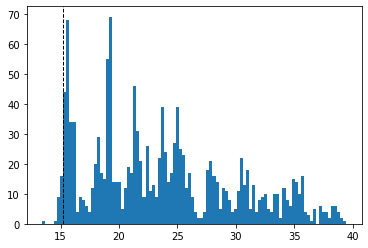

In [35]:
PE_MIN = 0
PE_MAX = 100

def peDistribution(id):
    pe = daily[daily['id']==id][['date','id','name','pe']]
    pe = pe[(pe['pe'] > PE_MIN) & (pe['pe'] < PE_MAX)]
    return pe['pe'].tolist()

id = 1723
pe = peDistribution(id)
y, x, _ = plt.hist(pe, 100)
df_id = out[out['id']==id]
name = df_id['name'].iloc[0]
now_pe = df_id['pe'].iloc[0]
most_pe = round(x[np.where(y == y.max())][0], 2)
eps = df_id['eps'].iloc[0]

print(f"[{len(pe)}]", name)
print('[PE] :', '目前:', now_pe, 'most:', most_pe)
print('[EPS]:','目前:', eps)
plt.axvline(now_pe, color='k', linestyle='dashed', linewidth=1)

plt.show()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

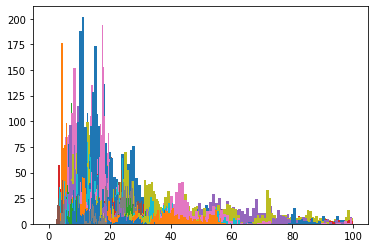

In [36]:
df_target = pd.DataFrame(columns=['count', 'id', 'name', 'now_pe','most_pe', 'avg_pe', 'eps', '收盤價', '偏離平均程度'])

def countTarget(id):
    pe = peDistribution(id)
    y, x, _ = plt.hist(pe, 100)
    df_id = out[out['id']==id]
    name = df_id['name'].iloc[0]
    now_pe = df_id['pe'].iloc[0]
    most_pe = round(x[np.where(y == y.max())][0], 2)
    avg_pe = df_id['avg_pe'].iloc[0]
    eps = df_id['eps'].iloc[0]
    close = df_id['收盤價'].iloc[0]
    cal_pe = min(most_pe, avg_pe)
    

    new_row = {'count': len(pe), 
               'id':id, 
               'name':name, 
               'now_pe':now_pe, 
               'most_pe':most_pe, 
               'avg_pe': avg_pe,
               'eps':eps, 
               '收盤價':close,
               '偏離平均程度':round(100*(cal_pe/now_pe - 1), 2)
              }
    
    df_target.loc[len(df_target)] = new_row
    

[countTarget(id) for id in filter1['id'].tolist()]

In [37]:
id = df_target['id'].isin(filter1['id'].tolist())

df_target_filter = (df_target[(df_target['count'] > 0)]) # 過濾pe數量>0
df_target_filter = df_target_filter.sort_values(by=['偏離平均程度'],ascending=False)
df_target_filter = df_target_filter.reset_index(drop=True)

df_target_filter

,count,id,name,now_pe,most_pe,avg_pe,eps,收盤價,偏離平均程度
0,1383,2303,聯電,6.65,16.78,19.24,6.79,45.15,152.33
1,1125,6670,復盛應用,5.60,11.55,11.66,34.47,193.00,106.25
2,1369,6271,同欣電,8.22,16.77,19.66,15.21,125.00,104.01
3,1383,4536,拓凱,6.57,12.85,14.56,25.34,166.50,95.59
4,1383,9802,鈺齊-KY,6.93,12.19,15.42,17.67,122.50,75.90
5,1297,6416,瑞祺電通,13.23,23.92,22.84,6.26,82.80,72.64
6,1383,3665,貿聯-KY,10.91,16.73,17.21,25.29,276.00,53.35
7,1383,2484,希華,7.91,12.08,16.70,4.33,34.25,52.72
8,1266,6166,凌華,16.79,24.86,46.48,3.86,64.80,48.06
9,1383,3030,德律,8.75,12.51,12.56,6.78,59.30,42.97


In [38]:
# 偏離程度>20
bias = df_target_filter['偏離平均程度'] > 20
isLong = df_target_filter['id'].isin(long_ids)
isTorn = df_target_filter['id'].isin(torn_ids)
df_target_filter[bias & isLong].to_csv(f'{today}_long.csv')
df_target_filter[bias & isTorn].to_csv(f'{today}_torn.csv')
df_target_filter[bias].to_csv(f'{today}_filter.csv')
df_target_filter[bias]

,count,id,name,now_pe,most_pe,avg_pe,eps,收盤價,偏離平均程度
0,1383,2303,聯電,6.65,16.78,19.24,6.79,45.15,152.33
1,1125,6670,復盛應用,5.60,11.55,11.66,34.47,193.00,106.25
2,1369,6271,同欣電,8.22,16.77,19.66,15.21,125.00,104.01
3,1383,4536,拓凱,6.57,12.85,14.56,25.34,166.50,95.59
4,1383,9802,鈺齊-KY,6.93,12.19,15.42,17.67,122.50,75.90
5,1297,6416,瑞祺電通,13.23,23.92,22.84,6.26,82.80,72.64
6,1383,3665,貿聯-KY,10.91,16.73,17.21,25.29,276.00,53.35
7,1383,2484,希華,7.91,12.08,16.70,4.33,34.25,52.72
8,1266,6166,凌華,16.79,24.86,46.48,3.86,64.80,48.06
9,1383,3030,德律,8.75,12.51,12.56,6.78,59.30,42.97


In [39]:
bias_ids = df_target_filter[bias]['id'].tolist()
df_prob[df_prob['id'].isin(bias_ids)].to_csv(f'{today}_probility.csv', index=False)

# 更新每月filter

In [41]:
# 需更新local的filter.csv檔案,再依據檔案新增新的
old = pd.read_csv('filter.csv') # 20230809
new = pd.merge(old, df_target_filter[bias][['id','name','收盤價']], how='outer')
new.rename(columns = {'收盤價': today}, inplace = True)
print(len(old), len(new))
new.to_csv(f"filter.csv", index = False)
new

352 352


,id,name,202207,202208,202209,202210,202211,20221128,20221213,202301,202302,202303,202304,20230502,20230524,20230615,20230711,20230724,20230809
0,1104,環泥,22.30,21.65,NaN,20.30,20.85,21.80,22.75,23.25,23.60,25.55,26.75,28.75,27.85,31.25,29.90,NaN,NaN
1,1108,幸福,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.10,16.10,16.50,15.35,16.30,16.55,NaN,NaN
2,1203,味王,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.20,38.30,NaN,41.60,NaN,NaN,NaN,NaN
3,1307,三芳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.80,21.20,21.15,21.00,23.80,NaN,NaN,NaN,NaN
4,1319,東陽,NaN,NaN,NaN,NaN,NaN,45.60,47.35,43.10,43.60,46.80,47.80,48.55,51.10,54.20,51.40,51.90,NaN
5,1342,八貫,NaN,NaN,82.50,76.30,80.20,87.60,NaN,NaN,NaN,NaN,NaN,146.50,131.00,NaN,NaN,115.00,NaN
6,1434,福懋,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.85,28.30,28.35,NaN,NaN,NaN,NaN,NaN
7,1444,力麗,NaN,NaN,11.75,NaN,10.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1476,儒鴻,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,496.50,470.50,494.00,487.50,NaN,NaN,NaN,NaN,NaN
9,1477,聚陽,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.50,232.50,223.50,225.50,227.50,NaN,NaN,NaN,NaN


In [40]:
db.close()